In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Once the repo is cloned then:
#best practice remove and reeinstal fspec


# instal using the setup.py inside the sam2 repo
#pip install e . (not necessary)
#pip install -e ".[demo]"


#install also to vizualize figures
!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-glx
!sudo apt-get install -y libglib2.0-0

#Necessary dependencies
!rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*
!pip install fsspec==2024.6.1 --force-reinstall --no-deps
!pip install shapely
!pip install s3fs
!pip install rasterio

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [921 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2944 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2221 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1135 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1424 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3041 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [

## Running an example of general segmentation using SAM2

In this example, the model segments everything it finds in the image.


In [14]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [15]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Geting the image from Solafune competition uploaded to my s3 bucket

# Finetuning by retraining the model with solafune's data

In [16]:
import numpy as np
import rasterio
from shapely.geometry import Polygon
from shapely.ops import transform
import cv2
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset, DataLoader
# Load Json
import s3fs
import json
import torch.optim as optim
from torch.cuda.amp import GradScaler
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator



In [17]:

train_annotation_s3_uri = 's3://solafune/train_annotation.json'


def polygon_to_mask(polygon, width, height):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return torch.tensor(np.array(mask), dtype=torch.float32)

def load_image(image_s3_uri):
    """Load an image from S3 and convert it to a NumPy array."""
    # Open the image using rasterio
    with rasterio.open(image_s3_uri) as src:
        # Read the image data
        image = src.read()  # This will read all the bands
        image = np.moveaxis(image, 0, -1)  # Move channels to the last dimension
        image = image[:, :, :3]  # Assuming you want to use only the first 3 bands (R, G, B)
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        image_normalized = image_normalized.astype(np.uint8)
    return image_normalized

def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None
    
def load_original_annotations(annotation_s3_uri):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    return data


# List of image filenames
image_filenames = [img['file_name'] for img in load_original_annotations(train_annotation_s3_uri)['images']]

#image_filenames = ['train_28.tif'] # set a quick training with specific images
image_s3_prefix = 's3://solafune/train_images/images'



In [18]:
import random
import matplotlib.pyplot as plt
import numpy as np

def read_batch(image_filenames, annotations, image_s3_prefix):
    # Select a random image
    image_filename = random.choice(image_filenames)
    image_s3_uri = os.path.join(image_s3_prefix, image_filename)
    
    # Load image using the existing function
    image = load_image(image_s3_uri)
    
    # Load annotations
    annotation = load_annotations(annotations, image_filename)
    
    height, width = image.shape[:2]
    masks = []
    points = []
    
    for ann in annotation:
        mask = polygon_to_mask(ann['segmentation'], width, height).numpy()
        masks.append(mask)

        # Choose a random point from the mask
        coords = np.argwhere(mask > 0)
        if len(coords) == 0:
            continue  # skip empty masks
        yx = np.array(coords[np.random.randint(len(coords))])
        points.append([yx[1], yx[0]])  # Store as (x, y) coordinates
    
    return image, np.array(masks), np.array(points)


In [19]:

# Load the model
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt" # try large sam2_hiera_large.pt
model_cfg = "sam2_hiera_l.yaml" #"sam2_hiera_l.yaml" for large
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# # Load the saved model state
# saved_state = torch.load("model_small.torch")
# predictor.model.load_state_dict(saved_state)

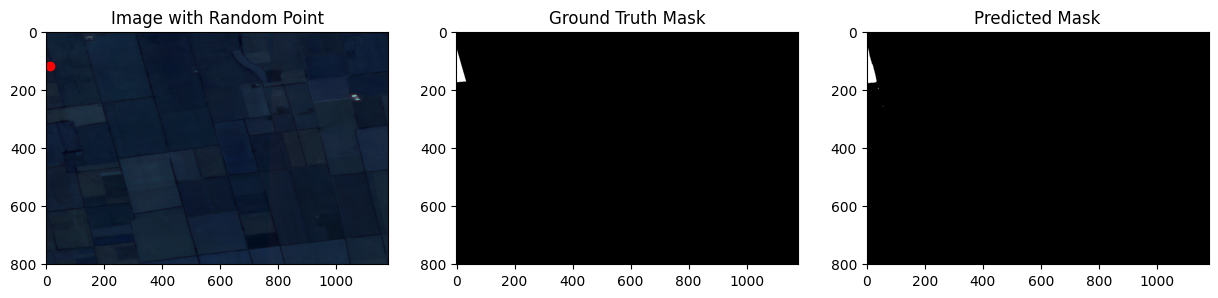

[[ 14 118]]


In [20]:


# Function to visualize the image, GT mask, and predicted mask
def visualize_image_and_masks(image, gt_mask, prd_mask, point):
    plt.figure(figsize=(15, 5))

    # Plot image with random point
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.scatter(point[0], point[1], color='red')
    plt.title("Image with Random Point")

    # Plot GT mask
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(prd_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Test the read_batch function and visualize the result
image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Set image in the predictor
predictor.set_image(image)

# Use the first point in the batch
input_point = points[0].reshape(1, 2)  # Correct shape for the point
input_label = np.array([1])  # Assuming binary classification for points

# Generate prompt and mask predictions using the predict method
masks_pred, scores, logits = predictor.predict(
    point_coords=input_point,  # Point coordinates
    point_labels=input_label,  # Labels for the point (foreground/background)
    multimask_output=False  # Single mask output
)

prd_mask = masks_pred[0]  # Get the predicted mask

# Visualize
visualize_image_and_masks(image, masks[0], prd_mask, points[0])
print(input_point)


In [28]:
import matplotlib.pyplot as plt

# Function to visualize the masks
def visualize_masks(gt_mask, prd_mask, iou):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(gt_mask.cpu().numpy(), cmap='gray')
    plt.title("Ground Truth Mask")
    
    plt.subplot(1, 3, 2)
    plt.imshow(prd_mask.cpu().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow((gt_mask & prd_mask).cpu().numpy(), cmap='gray')
    plt.title(f"Intersection (IoU: {iou:.4f})")
    
    plt.show()


# Function to print memory usage
def print_memory_usage(iteration):
    allocated_memory = torch.cuda.memory_allocated()
    reserved_memory = torch.cuda.memory_reserved()
    print(f"Iteration {iteration}, Allocated Memory: {allocated_memory / 1024**3:.4f} GB, Reserved Memory: {reserved_memory / 1024**3:.4f} GB")

# Function to calculate IoU using torch.logical_and and torch.logical_or
def calculate_iou_torch(gt_mask, pred_mask):
    inter = torch.logical_and(gt_mask, pred_mask).float().sum()
    union = torch.logical_or(gt_mask, pred_mask).float().sum()
    iou = (inter + 1e-6) / (union + 1e-6)
    return iou
# Function to check if weights have been updated
def check_weight_updates(model, old_state_dict):
    updated = False
    for name, param in model.named_parameters():
        if not torch.equal(param.data, old_state_dict[name].data):
            updated = True
            break
    return updated

# Function to calculate IoU between two masks (same as provided)
def calculate_iou(gt_mask, pred_mask):
    inter = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()
    iou = inter / (union + 1e-5)
    return iou.item()


# Main Train Loop

In [65]:
import torch
import torch.optim as optim
import numpy as np
import gc


# Set training parameters

predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler() # mixed precision

# Training loop
for itr in range(10000):
    try:
        # Manually trigger garbage collection
        gc.collect()
        torch.cuda.empty_cache()

        with torch.cuda.amp.autocast():
            # Read a batch of data
            image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)

            # Set image in the predictor
            predictor.set_image(image)

            # Convert ground truth masks to uint8 for IoU calculation
            gt_mask = masks[0].astype(np.uint8)
            gt_mask = torch.tensor(gt_mask, dtype=torch.float32).unsqueeze(0).cuda()

            # Use the first point in the batch
            input_point = points[0].reshape(1, 2)
            input_label = np.array([1])  # Assuming binary classification for points

            # Prompt encoding
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                input_point, input_label, box=None, mask_logits=None, normalize_coords=True
            )
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords, labels), boxes=None, masks=None
            )

            # Mask decoder
            batched_mode = unnorm_coords.shape[0] > 1  # multi-object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])  # Upscale the masks to the original image resolution

            # Segmentation Loss calculation
            prd_mask = torch.sigmoid(prd_masks[:, 0])  # Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 1e-5) -
                        (1 - gt_mask) * torch.log(1 - prd_mask + 1e-5)).mean()  # cross entropy loss
            
            print(image.shape)
            print(gt_mask.shape)
            print(prd_mask.shape)
            # Score loss calculation (intersection over union) IOU
            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05  # mix losses

            # Save model's current state_dict before the update
            old_state_dict = {name: param.clone() for name, param in predictor.model.named_parameters()}

            # Apply backpropagation
            optimizer.zero_grad()  # empty gradient
            scaler.scale(loss).backward()  # Backpropagate
            scaler.step(optimizer)
            scaler.update()  # Mixed precision update

            # Check if weights have been updated
            if check_weight_updates(predictor.model, old_state_dict):
                print(f"Iteration {itr}: Weights have been updated.")
            else:
                print(f"Iteration {itr}: No weight updates detected.")

            if itr % 1000 == 0:
                torch.save(predictor.model.state_dict(), "model.torch")
                print("Model saved")

            # Display results
            mean_iou = np.mean(iou.cpu().detach().numpy())
            print("step)", itr, "Accuracy(IOU)=", mean_iou)

        # Explicitly delete tensors and free memory
        del image, masks, points, gt_mask, prd_mask, seg_loss, score_loss, loss
        torch.cuda.empty_cache()
        gc.collect()

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Iteration {itr} skipped due to OOM error.")
            torch.cuda.empty_cache()
            gc.collect()
        else:
            raise e


<>:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
<>:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
/tmp/ipykernel_2457/2469363162.py:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  input_label = np.array([[1.]
/tmp/ipykernel_2457/2469363162.py:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  input_label = np.array([[1.]
/tmp/ipykernel_2457/2469363162.py:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  input_label = np.array([[1.]
/tmp/ipykernel_2457/2469363162.py:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  input_label = np.array([[1.]
/tmp/ipykernel_2457/2469363162.py:34: SyntaxWarning: list indices must be integers or slices, not float; perhaps you missed a comma?
  input

TypeError: list indices must be integers or slices, not float

In [26]:
import torch
import torch.optim as optim
import numpy as np
import gc

# Convert model to use float16
predictor.model.half()

# Set training parameters

predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler() # mixed precision
# Function to print memory usage


# Training loop
for itr in range(10000):
    try:
        # Manually trigger garbage collection
        gc.collect()
        torch.cuda.empty_cache()

        # Print memory usage at the beginning of the iteration
        #print_memory_usage(itr)
        
        with torch.cuda.amp.autocast():
            # Read a batch of data
            image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)
            
            # Set image in the predictor
            predictor.set_image(image)
            
            # Convert ground truth masks to uint8 for IoU calculation
            gt_mask = masks[0].astype(np.uint8)

            # Use the first point in the batch
            input_point = points[0].reshape(1, 2)
            input_label = np.array([1])  # Assuming binary classification for points

            # Generate prompt and mask predictions using the predict method
            masks_pred, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False
            )

            # Convert the predicted mask to uint8 for IoU calculation
            prd_mask = masks_pred[0].astype(np.uint8)

            # Calculate IoU using the same method as in the visualization code
            iou = calculate_iou(gt_mask, prd_mask)

            # Convert the ground truth mask and predicted mask to tensors for loss calculation
            gt_masks_tensor = torch.tensor(gt_mask, dtype=torch.float32).unsqueeze(0).cuda()
            prd_mask_tensor = torch.tensor(prd_mask, dtype=torch.float32, requires_grad=True).unsqueeze(0).cuda()

            # Segmentation loss calculation (cross-entropy loss)
            seg_loss = (-gt_masks_tensor * torch.log(prd_mask_tensor + 1e-5) - 
                        (1 - gt_masks_tensor) * torch.log(1 - prd_mask_tensor + 1e-5)).mean()

            # Convert iou to a tensor for computation
            mean_iou_tensor = torch.tensor(iou, dtype=torch.float32).cuda()
            
            # Compute the score loss
            score_loss = torch.abs(scores[0] - mean_iou_tensor).mean()

            # Total loss
            loss = seg_loss + score_loss * 0.05
            # Save model's current state_dict before the update
            old_state_dict = {name: param.clone() for name, param in predictor.model.named_parameters()}


            # Backpropagation
            optimizer.zero_grad(set_to_none=True)  # Ensure gradients are zeroed out correctly
            scaler.scale(loss).backward()

            # Check if the scaler has recorded any inf/nan values
            found_inf_per_device = scaler._found_inf_per_device(optimizer)
            optimizer.step()  # Standard optimizer step

            # Check if weights have been updated
            if check_weight_updates(predictor.model, old_state_dict):
                print(f"Iteration {itr}: Weights have been updated.")
            else:
                print(f"Iteration {itr}: No weight updates detected.")
            
            if any(found_inf_per_device.values()):
                scaler.update()  # Only update scaler if inf/nan values were recorded

            # Check if weights have been updated
            if check_weight_updates(predictor.model, old_state_dict):
                print(f"Iteration {itr}: Weights have been updated.")
            else:
                print(f"Iteration {itr}: No weight updates detected.")

            if itr % 1000 == 0:
                torch.save(predictor.model.state_dict(), "model.torch")
                print(f"Model saved at iteration {itr}")

            # Display results (optional)
            if itr % 1 == 0:
                print(f"Iteration {itr}, Loss: {loss.item():.4f}, IOU: {iou:.4f}")


        # Explicitly delete tensors and free memory
        del image, masks, points, gt_masks_tensor, prd_mask_tensor, seg_loss, score_loss, loss
        torch.cuda.empty_cache()
        gc.collect()  # Extra garbage collection to clear any lingering references

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Iteration {itr} skipped due to OOM error.")
            torch.cuda.empty_cache()
            gc.collect()
        else:
            raise e  # Re-raise other exceptions


Iteration 0: No weight updates detected.
Iteration 0: No weight updates detected.
Model saved at iteration 0
Iteration 0, Loss: 0.0217, IOU: 0.3803
Iteration 1: No weight updates detected.
Iteration 1: No weight updates detected.
Iteration 1, Loss: 0.0214, IOU: 0.2401


/tmp/ipykernel_2457/2021245419.py:18: RuntimeWarning: invalid value encountered in cast
  image_normalized = image_normalized.astype(np.uint8)


Iteration 2: No weight updates detected.
Iteration 2: No weight updates detected.
Iteration 2, Loss: 11.5171, IOU: 0.0023


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff2cfc26260>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Iteration 3: No weight updates detected.
Iteration 3: No weight updates detected.
Iteration 3, Loss: 0.1475, IOU: 0.0956
Iteration 4: No weight updates detected.
Iteration 4: No weight updates detected.
Iteration 4, Loss: 0.0016, IOU: 0.9687
Iteration 5: No weight updates detected.
Iteration 5: No weight updates detected.
Iteration 5, Loss: 0.0038, IOU: 0.9657
Iteration 6: No weight updates detected.
Iteration 6: No weight updates detected.
Iteration 6, Loss: 0.1251, IOU: 0.0182
Iteration 7: No weight updates detected.
Iteration 7: No weight updates detected.
Iteration 7, Loss: 0.0504, IOU: 0.0915
Iteration 8: No weight updates detected.
Iteration 8: No weight updates detected.
Iteration 8, Loss: 0.1340, IOU: 0.0958
Iteration 9: No weight updates detected.
Iteration 9: No weight updates detected.
Iteration 9, Loss: 11.5299, IOU: 0.0011
Iteration 10: No weight updates detected.
Iteration 10: No weight updates detected.
Iteration 10, Loss: 0.0033, IOU: 0.9543
Iteration 11: No weight upda

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff2cfc26260>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Iteration 177: No weight updates detected.
Iteration 177: No weight updates detected.
Iteration 177, Loss: 0.0074, IOU: 0.9454
Iteration 178: No weight updates detected.
Iteration 178: No weight updates detected.
Iteration 178, Loss: 0.0173, IOU: 0.6033
Iteration 179: No weight updates detected.
Iteration 179: No weight updates detected.
Iteration 179, Loss: 1.6138, IOU: 0.0010
Iteration 180: No weight updates detected.
Iteration 180: No weight updates detected.
Iteration 180, Loss: 0.0256, IOU: 0.4376
Iteration 181: No weight updates detected.
Iteration 181: No weight updates detected.
Iteration 181, Loss: 0.2043, IOU: 0.0618
Iteration 182: No weight updates detected.
Iteration 182: No weight updates detected.
Iteration 182, Loss: 0.1817, IOU: 0.0064
Iteration 183: No weight updates detected.
Iteration 183: No weight updates detected.
Iteration 183, Loss: 0.1394, IOU: 0.2138
Iteration 184: No weight updates detected.
Iteration 184: No weight updates detected.
Iteration 184, Loss: 0.07

KeyboardInterrupt: 

In [ ]:
torch.save(predictor.model.state_dict(), "model_large.torch")

In [119]:
import torch
import torch.optim as optim
import numpy as np

# Convert model to use float16
predictor.model.half()

# Optimizer
optimizer = optim.AdamW(params=predictor.model.parameters(), lr=1e-5, weight_decay=4e-5)
scaler = torch.cuda.amp.GradScaler()  # Mixed precision

# Create a dummy image with the correct format
dummy_image = torch.randn(224, 224, 3).half().cpu().numpy()  # 3-channel image

# Use a dummy point in the image and a dummy label
dummy_point = np.array([[112, 112]])  # Dummy point in the center
dummy_label = np.array([1])  # Dummy label

# Set the dummy image using the predictor's set_image method
predictor.set_image(dummy_image)

# Run the prediction using the dummy point and label
masks_pred, scores, logits = predictor.predict(
    point_coords=dummy_point,
    point_labels=dummy_label,
    multimask_output=False
)

# Convert the predicted mask to uint8 for IoU calculation
prd_mask = masks_pred[0].astype(np.uint8)

# Create a dummy ground truth mask
gt_mask = (np.random.rand(224, 224) > 0.5).astype(np.uint8)

# Convert the ground truth mask and predicted mask to tensors for loss calculation
gt_masks_tensor = torch.tensor(gt_mask, dtype=torch.float32).unsqueeze(0).cuda()
prd_mask_tensor = torch.tensor(prd_mask, dtype=torch.float32, requires_grad=True).unsqueeze(0).cuda()

# Calculate IoU using the same method as in the visualization code
iou = calculate_iou(gt_mask, prd_mask)

# Calculate segmentation loss (cross-entropy)
seg_loss = (-gt_masks_tensor * torch.log(prd_mask_tensor + 1e-5) - 
            (1 - gt_masks_tensor) * torch.log(1 - prd_mask_tensor + 1e-5)).mean()

# Convert iou to a tensor for computation
mean_iou_tensor = torch.tensor(iou, dtype=torch.float32).cuda()

# Compute the score loss
score_loss = torch.abs(scores[0] - mean_iou_tensor).mean()

# Total loss
loss = seg_loss + score_loss * 0.05

# Save model's current state_dict before the update
old_state_dict = {name: param.clone() for name, param in predictor.model.named_parameters()}

# Backpropagation
optimizer.zero_grad(set_to_none=True)  # Ensure gradients are zeroed out correctly
scaler.scale(loss).backward()

# Check if the scaler has recorded any inf/nan values
found_inf_per_device = scaler._found_inf_per_device(optimizer)
optimizer.step()  # Standard optimizer step

# Check if weights have been updated
if check_weight_updates(predictor.model, old_state_dict):
    print(f"Dummy Test: Weights have been updated.")
else:
    print(f"Dummy Test: No weight updates detected.")


Dummy Test: No weight updates detected.


In [97]:
# Function to calculate IoU between two masks using bitwise operations
def calculate_iou(gt_mask, pred_mask):
    # Ensure masks are binary
    gt_mask = gt_mask > 0.5
    pred_mask = pred_mask > 0.5
    
    # Calculate intersection and union using bitwise operations
    inter = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()
    
    # Compute IoU and return it as a scalar value
    iou = inter / (union + 1e-5)  # Adding epsilon to prevent division by zero
    return iou.item()


## Test the results

IoU (Current Saved State): 0.9259
IoU (SAM2 Checkpoint): 0.9245


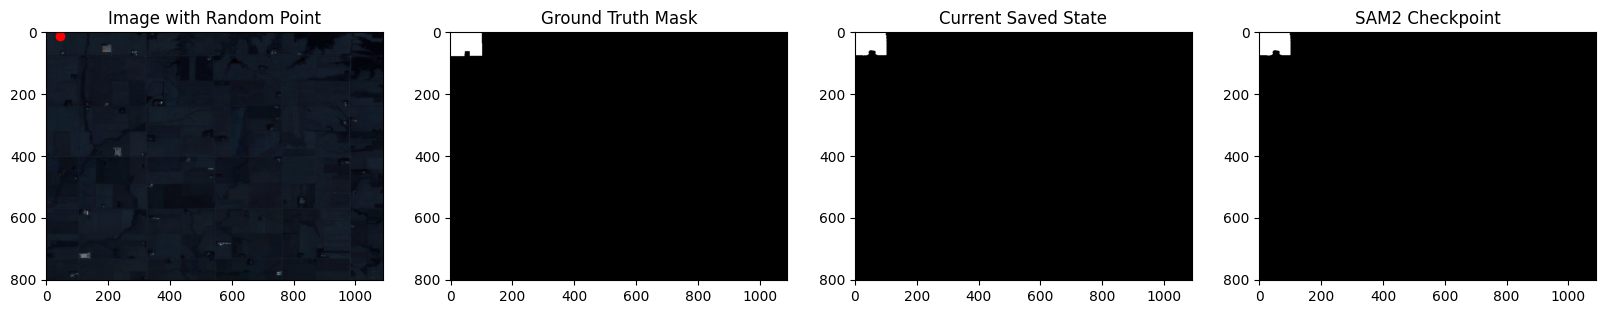

In [104]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Function to calculate IoU between two masks
def calculate_iou(gt_mask, pred_mask):
    inter = (gt_mask & pred_mask).sum()
    union = (gt_mask | pred_mask).sum()
    iou = inter / (union + 1e-5)
    return iou.item()

# Function to visualize the image, GT mask, and predicted masks from different models
def visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, point):
    plt.figure(figsize=(20, 4))

    # Plot image with random point
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.scatter(point[0], point[1], color='red')
    plt.title("Image with Random Point")

    # Plot GT mask
    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot Predicted mask (Current saved state)
    plt.subplot(1, 4, 3)
    plt.imshow(prd_mask_saved, cmap='gray')
    plt.title("Current Saved State")

    # Plot Predicted mask (SAM2 checkpoint)
    plt.subplot(1, 4, 4)
    plt.imshow(prd_mask_checkpoint, cmap='gray')
    plt.title("SAM2 Checkpoint")

    plt.show()

# Test the read_batch function and visualize the result
image, masks, points = read_batch(image_filenames, train_annotation_s3_uri, image_s3_prefix)

# Use the first point in the batch
input_point = points[0].reshape(1, 2)  # Correct shape for the point
input_label = np.array([1])  # Assuming binary classification for points

# 1. Load the saved model state and predict
saved_state = torch.load("model_large.torch")
predictor.model.load_state_dict(saved_state)
predictor.set_image(image)
masks_pred_saved, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)
prd_mask_saved = masks_pred_saved[0].astype(np.uint8)

# 2. Load the SAM2 checkpoint and predict
sam2_checkpoint = "./segment-anything-2/checkpoints/sam2_hiera_large.pt"  # Adjust to large if needed
model_cfg = "sam2_hiera_l.yaml"  # Adjust to large if needed
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor_checkpoint = SAM2ImagePredictor(sam2_model)
predictor_checkpoint.set_image(image)
masks_pred_checkpoint, _, _ = predictor_checkpoint.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False
)
prd_mask_checkpoint = masks_pred_checkpoint[0].astype(np.uint8)

# Convert ground truth mask to binary
gt_mask = masks[0].astype(np.uint8)

# Calculate IoU
iou_saved_state = calculate_iou(gt_mask, prd_mask_saved)
iou_checkpoint = calculate_iou(gt_mask, prd_mask_checkpoint)

print(f"IoU (Current Saved State): {iou_saved_state:.4f}")
print(f"IoU (SAM2 Checkpoint): {iou_checkpoint:.4f}")

# Visualize all the results
visualize_image_and_masks(image, gt_mask, prd_mask_saved, prd_mask_checkpoint, points[0])
